<a href="https://colab.research.google.com/github/laurence-lin/Kaggle_competition/blob/master/final_project_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
import lightgbm as lgb
import sklearn
import cv2

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import os
import gc

pd.set_option('display.max_columns' , 500)
pd.set_option('display.width', 300)

print('Library imported.')


Library imported.


In [2]:
import multiprocessing

multiprocessing.cpu_count()

2

In [3]:
from google.colab import files

uploaded = files.upload() # upload kaggle.json
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/ 
!kaggle competitions download -c competitive-data-science-predict-future-sales
!unzip \*.zip

Saving kaggle.json to kaggle.json
 38% 5.00M/13.3M [00:00<00:00, 46.1MB/s]
100% 13.3M/13.3M [00:00<00:00, 85.0MB/s]
  0% 0.00/1.02M [00:00<?, ?B/s]
100% 1.02M/1.02M [00:00<00:00, 146MB/s]
  0% 0.00/2.91k [00:00<?, ?B/s]
100% 2.91k/2.91k [00:00<00:00, 2.96MB/s]
  0% 0.00/468k [00:00<?, ?B/s]
100% 468k/468k [00:00<00:00, 168MB/s]
  0% 0.00/3.49k [00:00<?, ?B/s]
100% 3.49k/3.49k [00:00<00:00, 3.35MB/s]
  0% 0.00/368k [00:00<?, ?B/s]
100% 368k/368k [00:00<00:00, 117MB/s]
Archive:  items.csv.zip
  inflating: items.csv               

Archive:  test.csv.zip
  inflating: test.csv                

Archive:  sales_train.csv.zip
  inflating: sales_train.csv         

Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   

4 archives were successfully processed.


In [4]:

item_cat = pd.read_csv('item_categories.csv')
item = pd.read_csv('items.csv')
sale_train = pd.read_csv('sales_train.csv')
shops = pd.read_csv('shops.csv')

test = pd.read_csv('test.csv')

sample_submission = pd.read_csv('sample_submission.csv')

print('Files imported.')


Files imported.


In [5]:
print(test.head())
print(sample_submission.head())

   ID  shop_id  item_id
0   0        5     5037
1   1        5     5320
2   2        5     5233
3   3        5     5232
4   4        5     5268
   ID  item_cnt_month
0   0             0.5
1   1             0.5
2   2             0.5
3   3             0.5
4   4             0.5


In [6]:
print('Items: ')
print(item.head(), '\n')

print('Item category:')
print(item_cat.head(), '\n')

print('Shops data:')
print(shops.head(), '\n')

print('Sales train_data')
print(sale_train.head(), '\n')




Items: 
                                           item_name  item_id  item_category_id
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0                40
1  !ABBYY FineReader 12 Professional Edition Full...        1                76
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2                40
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3                40
4        ***КОРОБКА (СТЕКЛО)                       D        4                40 

Item category:
        item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4 

Shops data:
                        shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ "Центральный" фран        1
2                Адыгея ТЦ "Мега"        2
3  Балашиха ТРК "Октябрь-Киномир"      

###I assume that since I have shop_id and item_category_id, shop name and item_category name is unnecessary. However, we preserve this feature first, assume meaningless features may contain data leakage.
###Thus, when I combine the dataset.

In [7]:
item = item.merge(item_cat, how = 'left', on = 'item_category_id')
sale_train = sale_train.merge(shops, how = 'left', on = 'shop_id')
train = sale_train.merge(item, how = 'left', on = 'item_id')
test = test.merge(item, how = 'left', on = 'item_id')
test = test.merge(shops, how = 'left', on = 'shop_id')
print('Train data:')
print(train.shape)
print(train.head())

print('Test data:')
print(test.shape)
print(test.head())

Train data:
(2935849, 10)
         date  date_block_num  shop_id  item_id  item_price  item_cnt_day               shop_name                                 item_name  item_category_id                   item_category_name
0  02.01.2013               0       59    22154      999.00           1.0  Ярославль ТЦ "Альтаир"                         ЯВЛЕНИЕ 2012 (BD)                37                       Кино - Blu-Ray
1  03.01.2013               0       25     2552      899.00           1.0     Москва ТРК "Атриум"  DEEP PURPLE  The House Of Blue Light  LP                58                       Музыка - Винил
2  05.01.2013               0       25     2552      899.00          -1.0     Москва ТРК "Атриум"  DEEP PURPLE  The House Of Blue Light  LP                58                       Музыка - Винил
3  06.01.2013               0       25     2554     1709.05           1.0     Москва ТРК "Атриум"  DEEP PURPLE  Who Do You Think We Are  LP                58                       Музыка - Винил

##Task framework: Use 2013/1 ~ 2015/10 data, to predict 2015/11 data
###We have training data with 10 features, test data with 6 features(not counting the ID). Train data contains features that test data don't have: [date, date_block_num, item_cnt_day]. 
###We should take into account the time context of the data
###1. Given current shop and item, predict total sales of whole month
###2. Apply time sequence feature, (shop + item) * several months + past monthly  sales * several months = future monthly sales

In [8]:
# First preprocess date data: For train set, extract year and month from date column
# Original date format: dd/mm/yyyy
train['date'] = pd.to_datetime(train['date'], format = '%d.%m.%Y')
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year
print(train.info())
print(train.head())



<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 0 to 2935848
Data columns (total 12 columns):
 #   Column              Dtype         
---  ------              -----         
 0   date                datetime64[ns]
 1   date_block_num      int64         
 2   shop_id             int64         
 3   item_id             int64         
 4   item_price          float64       
 5   item_cnt_day        float64       
 6   shop_name           object        
 7   item_name           object        
 8   item_category_id    int64         
 9   item_category_name  object        
 10  month               int64         
 11  year                int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 291.2+ MB
None
        date  date_block_num  shop_id  item_id  item_price  item_cnt_day               shop_name                                 item_name  item_category_id                   item_category_name  month  year
0 2013-01-02               0    

In [9]:
# Since test data is from 2015 November, we could create date features for test data
test['month'] = 11
test['year'] = 2015
test['date_block_num'] = 34
print(test.head())

   ID  shop_id  item_id                                          item_name  item_category_id                   item_category_name               shop_name  month  year  date_block_num
0   0        5     5037                     NHL 15 [PS3, русские субтитры]                19                           Игры - PS3  Вологда ТРЦ "Мармелад"     11  2015              34
1   1        5     5320                    ONE DIRECTION  Made In The A.M.                55  Музыка - CD локального производства  Вологда ТРЦ "Мармелад"     11  2015              34
2   2        5     5233  Need for Speed Rivals (Essentials) [PS3, русск...                19                           Игры - PS3  Вологда ТРЦ "Мармелад"     11  2015              34
3   3        5     5232  Need for Speed Rivals (Classics) [Xbox 360, ру...                23                      Игры - XBOX 360  Вологда ТРЦ "Мармелад"     11  2015              34
4   4        5     5268               Need for Speed [PS4, русская версия]           

In [10]:
print(train.columns)
print(test.columns)

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day', 'shop_name', 'item_name', 'item_category_id', 'item_category_name', 'month', 'year'], dtype='object')
Index(['ID', 'shop_id', 'item_id', 'item_name', 'item_category_id', 'item_category_name', 'shop_name', 'month', 'year', 'date_block_num'], dtype='object')


###Now the only difference in train and test features is item_cnt_day.

In [11]:
#Start EDA for train and test data
print(train.head())
print(test.head())
# make the column of test aligned with train set
col_train = [col for col in train.columns if col in test.columns]
test = pd.concat([test['ID'], test[col_train]], axis = 1)


        date  date_block_num  shop_id  item_id  item_price  item_cnt_day               shop_name                                 item_name  item_category_id                   item_category_name  month  year
0 2013-01-02               0       59    22154      999.00           1.0  Ярославль ТЦ "Альтаир"                         ЯВЛЕНИЕ 2012 (BD)                37                       Кино - Blu-Ray      1  2013
1 2013-01-03               0       25     2552      899.00           1.0     Москва ТРК "Атриум"  DEEP PURPLE  The House Of Blue Light  LP                58                       Музыка - Винил      1  2013
2 2013-01-05               0       25     2552      899.00          -1.0     Москва ТРК "Атриум"  DEEP PURPLE  The House Of Blue Light  LP                58                       Музыка - Винил      1  2013
3 2013-01-06               0       25     2554     1709.05           1.0     Москва ТРК "Атриум"  DEEP PURPLE  Who Do You Think We Are  LP                58                

In [12]:
print(train.head())
print(test.head())

        date  date_block_num  shop_id  item_id  item_price  item_cnt_day               shop_name                                 item_name  item_category_id                   item_category_name  month  year
0 2013-01-02               0       59    22154      999.00           1.0  Ярославль ТЦ "Альтаир"                         ЯВЛЕНИЕ 2012 (BD)                37                       Кино - Blu-Ray      1  2013
1 2013-01-03               0       25     2552      899.00           1.0     Москва ТРК "Атриум"  DEEP PURPLE  The House Of Blue Light  LP                58                       Музыка - Винил      1  2013
2 2013-01-05               0       25     2552      899.00          -1.0     Москва ТРК "Атриум"  DEEP PURPLE  The House Of Blue Light  LP                58                       Музыка - Винил      1  2013
3 2013-01-06               0       25     2554     1709.05           1.0     Москва ТРК "Атриум"  DEEP PURPLE  Who Do You Think We Are  LP                58                

In [13]:
train.loc[train.index[train['item_cnt_day'] < 0], 'item_cnt_day'] = 0
len(train[train['item_cnt_day'] < 0])

0

In [15]:
# Sum up different days value into monthly
train['cnt_monthly'] = train.groupby(['year', 'month', 'shop_id', 'item_id'])['item_cnt_day'].transform(lambda x: x.sum())
print(train.head())

        date  date_block_num  shop_id  item_id  item_price  item_cnt_day               shop_name                                 item_name  item_category_id                   item_category_name  month  year  cnt_monthly
0 2013-01-02               0       59    22154      999.00           1.0  Ярославль ТЦ "Альтаир"                         ЯВЛЕНИЕ 2012 (BD)                37                       Кино - Blu-Ray      1  2013          1.0
1 2013-01-03               0       25     2552      899.00           1.0     Москва ТРК "Атриум"  DEEP PURPLE  The House Of Blue Light  LP                58                       Музыка - Винил      1  2013          1.0
2 2013-01-05               0       25     2552      899.00           0.0     Москва ТРК "Атриум"  DEEP PURPLE  The House Of Blue Light  LP                58                       Музыка - Винил      1  2013          1.0
3 2013-01-06               0       25     2554     1709.05           1.0     Москва ТРК "Атриум"  DEEP PURPLE  Who Do Yo

In [61]:
features = ['item_price', 'shop_name', 'item_name', 'item_category_id', 'item_category_name', 'item_cnt_day']
train_ = train.groupby(['year', 'month', 'shop_id', 'item_id'])[features]['item_cnt_day'].sum().to_frame('cnt_monthly').reset_index()
print(train_)

IndexError: ignored

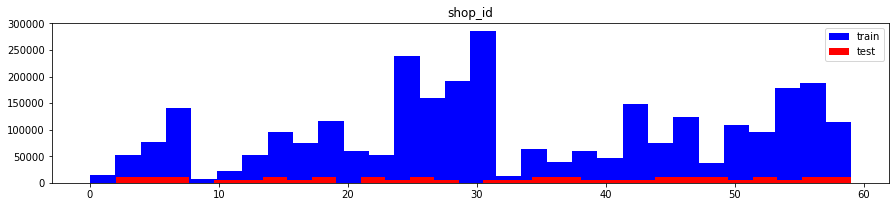

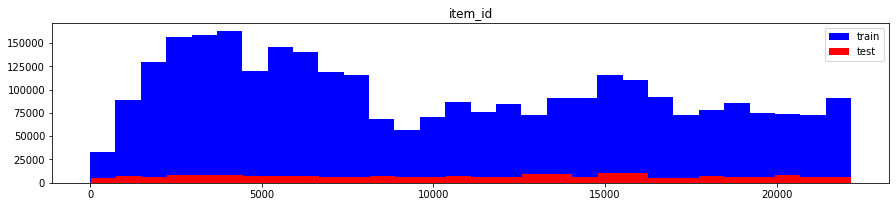

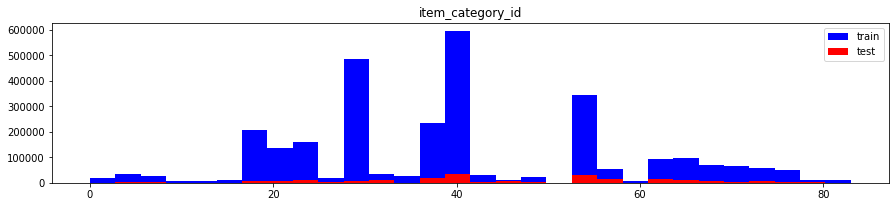

In [27]:
#Observe distributions of features in train and test set

cat_feature = ['shop_id', 'item_id', 'item_category_id']
for col in range(len(cat_feature)):
   plt.figure(figsize = (15, 10))
   plt.subplot(len(cat_feature), 1, col+1)
   plt.hist(train[cat_feature[col]], bins = 30, color = 'blue', label = 'train')
   plt.hist(test[cat_feature[col]], bins = 30, color = 'red', label = 'test')
   plt.title(str(cat_feature[col]))
   plt.legend()



###The train category features contains all distributions of test category features, though the distribution is not all shaped the same.

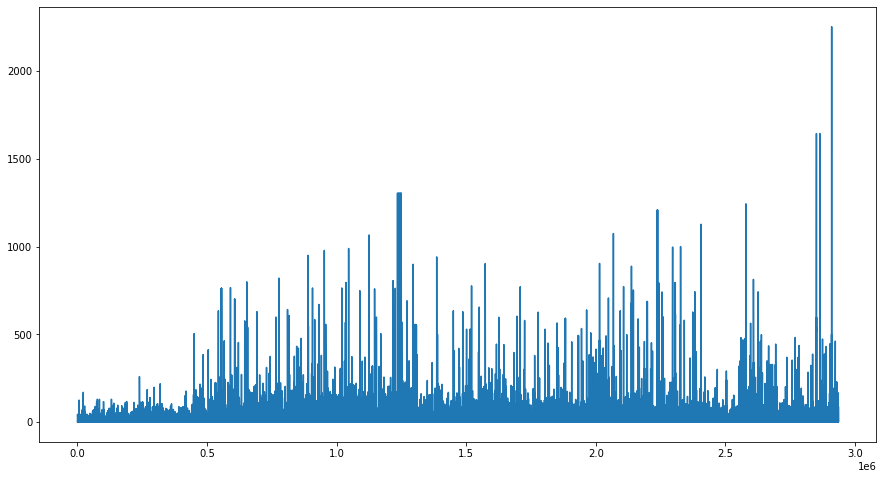

In [30]:
plt.figure(figsize = (15, 8))
plt.plot(train['cnt_monthly'])

In [31]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name,month,year,cnt_monthly
0,2013-01-02,0,59,22154,999.00,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,1,2013,1.0
1,2013-01-03,0,25,2552,899.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,1,2013,1.0
2,2013-01-05,0,25,2552,899.00,0.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,1,2013,1.0
3,2013-01-06,0,25,2554,1709.05,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,1,2013,1.0
4,2013-01-15,0,25,2555,1099.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,1,2013,1.0


###Assume some properties that my affect item monthly sells:
###Does different shop tend to sold more of less item?
###Does certain item category tend to sold more of less item?
###And the analyzation result comparing train and test set

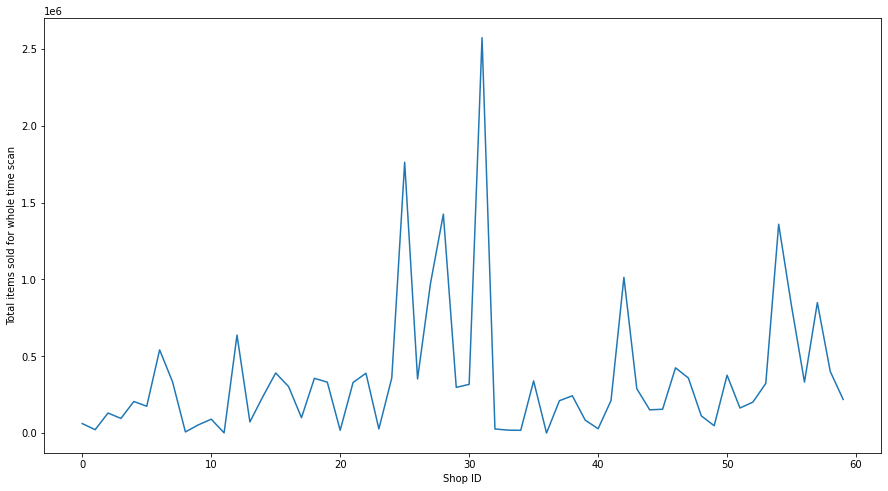

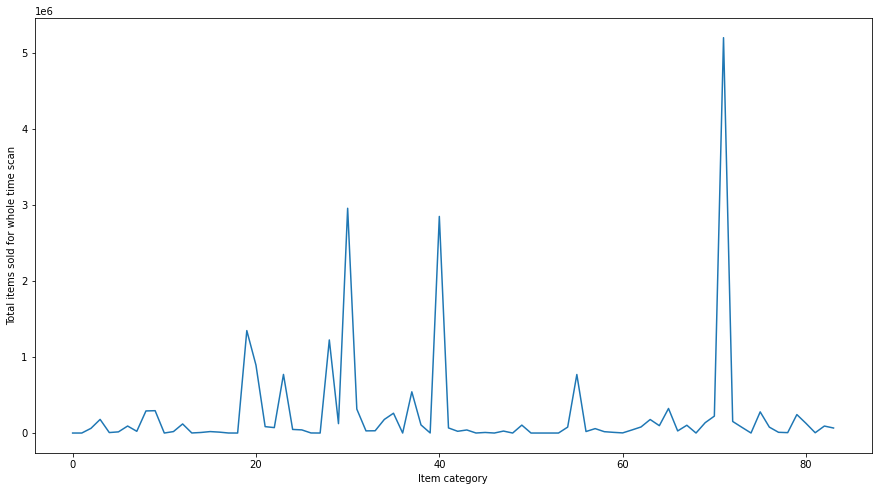

In [49]:
check = train.groupby('shop_id')['cnt_monthly'].sum()
plt.figure(1, figsize=(15, 8))
plt.xlabel('Shop ID')
plt.ylabel('Total items sold for whole time scan')
plt.plot(check)

check = train.groupby('item_category_id')['cnt_monthly'].sum()
plt.figure(2, figsize=(15, 8))
plt.xlabel('Item category')
plt.ylabel('Total items sold for whole time scan')
plt.plot(check)

In [38]:
test.head()

,ID,date_block_num,shop_id,item_id,shop_name,item_name,item_category_id,item_category_name,month,year
0,0,34,5,5037,"Вологда ТРЦ ""Мармелад""","NHL 15 [PS3, русские субтитры]",19,Игры - PS3,11,2015
1,1,34,5,5320,"Вологда ТРЦ ""Мармелад""",ONE DIRECTION Made In The A.M.,55,Музыка - CD локального производства,11,2015
2,2,34,5,5233,"Вологда ТРЦ ""Мармелад""","Need for Speed Rivals (Essentials) [PS3, русск...",19,Игры - PS3,11,2015
3,3,34,5,5232,"Вологда ТРЦ ""Мармелад""","Need for Speed Rivals (Classics) [Xbox 360, ру...",23,Игры - XBOX 360,11,2015
4,4,34,5,5268,"Вологда ТРЦ ""Мармелад""","Need for Speed [PS4, русская версия]",20,Игры - PS4,11,2015
